In [1]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import os
import zipfile
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from io import StringIO

import pytorch_lightning as pl

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib
from matplotlib.ticker import MaxNLocator

from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from torchmetrics.functional import accuracy

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from multiprocessing import cpu_count

### Styling Settings

In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 14, 10

tqdm.pandas()


In [3]:
# Random Seed Pytorch Lightning
pl.seed_everything(42)

Global seed set to 42


42

## Loading Data

In [4]:
import warnings
import yaml
#opening config file
options_path = '/Users/andreisuhov/Desktop/проект лаба/src/config.yml'
with open(options_path, 'r') as option_file:
    options = yaml.safe_load(option_file)

#сделаем красивый формат для дробных чисел
pd.set_option('display.float_format', '{:.2f}'.format)

#скроем возможные предупреждения
warnings.filterwarnings('ignore')

train_path = options['train_path']
train_deals_path = options['train_deals_path']
train_add_info_path = options['train_add_info_path']

df = pd.read_csv(train_path) #reading data from csv file train data

In [5]:
def get_all_tools_list(train_deals_path):
        alltools_list = np.array([])
        for filename in os.listdir(train_deals_path):
            if filename.endswith('.zip'): #take only zip files
                with zipfile.ZipFile(os.path.join(train_deals_path, filename), 'r') as zip_ref: 
                    for file in zip_ref.namelist():
                        with zip_ref.open(file) as f_in:#opening and reading files
                            file_content = f_in.read().decode('utf-8') #reading file's content 
                            content = StringIO(file_content) #making it csv file, so we can read it with "read_csv"
                            auxiliary_df = pd.read_csv(content, sep=";", names=['time','tool','quantity','sum'])
                            alltools_list = np.concatenate((alltools_list,  auxiliary_df['tool'].unique()))
        return  np.unique(alltools_list)

In [6]:
all_tools_list = get_all_tools_list(train_deals_path)

In [7]:
all_tools_df = pd.DataFrame(all_tools_list, columns=['tool'])
all_tools_df= all_tools_df.reset_index().rename(columns={'index': 'id'})
all_tools_df

,id,tool
0,0,ABRD
1,1,AF3000BL2
2,2,AFH3
3,3,AFKS
4,4,AFLT
...,...,...
1757,1757,YN2050CX2A
1758,1758,YNDX
1759,1759,YNH3
1760,1760,YNM3


In [8]:
LEN_OF_FEATURES = 200

In [13]:
def change_tools_columns(train_deals_path, all_tools_df):
        main_df = pd.DataFrame()
        
        for filename in os.listdir(train_deals_path):
            filename_id = filename[2:-4] # getting user id from folder's name
            if filename.endswith('.zip'): #take only zip files
                with zipfile.ZipFile(os.path.join(train_deals_path, filename), 'r') as zip_ref: 
                    for file in zip_ref.namelist():
                        with zip_ref.open(file) as f_in:#opening and reading files
                            file_content = f_in.read().decode('utf-8') #reading file's content 
                            content = StringIO(file_content) #making it csv file, so we can read it with "read_csv"
                            auxiliary_df = pd.read_csv(content, sep=";", names=['time','tool','quantity','sum'])

                            auxiliary_df['time'] = pd.to_datetime(auxiliary_df['time'])
                            # create a timedelta column representing the difference from a specific year (1953 in this case) in seconds
                            auxiliary_df['time_delta'] = (auxiliary_df['time'] - pd.to_datetime('1953-01-01 00:00:00.000')).dt.total_seconds()
                            # drop the original 'time' column
                            auxiliary_df = auxiliary_df.drop('time', axis=1)

                            new_auxiliary_df = pd.merge(auxiliary_df, all_tools_df, on='tool', how='left')
                            new_auxiliary_df = new_auxiliary_df.drop('tool', axis=1)

                            if len(new_auxiliary_df) < LEN_OF_FEATURES:
                                add_rows = LEN_OF_FEATURES - len(new_auxiliary_df)
                                zero_df = pd.DataFrame(np.zeros((add_rows, len(new_auxiliary_df.columns))), columns=new_auxiliary_df.columns)
                                new_auxiliary_df = pd.concat([new_auxiliary_df, zero_df], ignore_index=True)
                            
                            new_auxiliary_df.insert(0, 'user_id', filename_id)
                            main_df = main_df._append(new_auxiliary_df.iloc[:LEN_OF_FEATURES], ignore_index=True)                   
        
        return main_df

In [14]:
features_df = change_tools_columns( train_deals_path, all_tools_df)

In [15]:
def add_class(features_df, origin_df):
    origin_df = origin_df.rename(columns={'id': 'user_id'})
    features_df['user_id'] = pd.to_numeric(features_df['user_id'], downcast='integer')
    auxiliary_df = pd.merge(features_df, origin_df, on='user_id', how='left')
    return auxiliary_df

In [16]:
final_df = add_class(features_df, df)

In [ ]:
final_df  = final_df.drop(columns=['nickname','broker','start_sum', 'request', 'deals', 'income_rub', 'income_percent'], axis=1)

In [18]:
final_df.to_csv('features')

In [ ]:
final_df

### Preprocessing the data

In [ ]:
X_train, y_train = final_df.iloc[:,1:-1], final_df['class']
y_train = y_train[y_train.index % 200 == 0]

In [ ]:
FEATURE_COLUMNS = final_df.columns.tolist()[1:-1]
FEATURE_COLUMNS

['quantity', 'sum', 'time_delta', 'id']

In [ ]:
print(X_train.user_id.value_counts())
# This shows us that each sequence contains 128 datapoints

# confirming this
(X_train.user_id.value_counts() == LEN_OF_FEATURES).sum() == len(y_train)


AttributeError: 'DataFrame' object has no attribute 'user_id'

### Creating the sequences

I will group by series id

In [ ]:
sequences = []
for user_id, group in X_train.groupby("user_id"):
    sequence_features = group[FEATURE_COLUMNS]
    label = y_train[y_train.user_id == user_id].iloc[0].label
    sequences.append((sequence_features, label))

In [ ]:
sequences = []
for i in range(len(y_train)):
    sequences.append((X_train.iloc[i:i+LEN_OF_FEATURES], y_train.iloc[i]))

In [ ]:
# Each sequence
sequences[1]

(     quantity       sum    time_delta      id
 1       -2.00 116410.00 2200125240.00  865.00
 2       -1.00 116410.00 2200125240.00  865.00
 3       -1.00 116410.00 2200125240.00  865.00
 4        2.00 115230.00 2200127880.00  865.00
 5        2.00 115230.00 2200127880.00  865.00
 ..        ...       ...           ...     ...
 196     -1.00     10.00 2202741540.00  538.00
 197     -4.00     10.00 2202741540.00  538.00
 198     -2.00     93.00 2202801000.00  138.00
 199     -3.00     92.95 2202801180.00  138.00
 200     -8.00  14389.00 2199788460.00 1070.00
 
 [200 rows x 4 columns],
 2)

#### Splitting the Sequences into Training and Test Sequences

In [ ]:
train_sequences, test_sequences = train_test_split(sequences, test_size=0.2)
print("Number of Training Sequences: ", len(train_sequences))
print("Number of Testing Sequences: ", len(test_sequences))

Number of Training Sequences:  1219
Number of Testing Sequences:  305


### Create PyTorch Dataset

In [ ]:
class SurfaceDataset(Dataset):
    def __init__(self, sequences):
        super().__init__()
        self.sequences = sequences
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        sequence, label = self.sequences[idx]
        return dict(
            sequence = torch.Tensor(sequence.to_numpy()),
            label = torch.tensor(label).long()
        )

In [ ]:
class SurfaceDataModule(pl.LightningDataModule):
    def __init__(self, train_sequences, test_sequences, batch_size):
        super().__init__()
        self.train_sequences = train_sequences
        self.test_sequences = test_sequences
        self.batch_size = batch_size
    
    def setup(self, stage=None):
        self.train_dataset = SurfaceDataset(self.train_sequences)
        self.test_dataset = SurfaceDataset(self.test_sequences)
    
    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size = self.batch_size,
            shuffle = False,
            num_workers = cpu_count()
        )

    def val_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size = self.batch_size,
            shuffle = False,
            num_workers = cpu_count()
        )
    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size = self.batch_size,
            shuffle = False,
            num_workers = cpu_count()
        )


### Model Parameters

In [ ]:
N_EPOCHS = 250
BATCH_SIZE = 64

data_module = SurfaceDataModule(train_sequences, test_sequences, BATCH_SIZE)

### Model Architecture

In [ ]:
class SequenceModel(nn.Module):
  def __init__(self, n_features, n_classes, n_hidden=256, n_layers=3):
    super().__init__()

    self.lstm = nn.LSTM(
        input_size = n_features,
        hidden_size = n_hidden,
        batch_first = True,
        num_layers = n_layers, # Stack LSTMs
        dropout = 0.2  # This model works on a lot of regularisation
    )

    self.classifier = nn.Linear(n_hidden, n_classes)

  def forward(self, x):
    self.lstm.flatten_parameters()  # For distrubuted training

    _, (hidden, _) = self.lstm(x)
    # We want the output from the last layer to go into the final
    # regressor linear layer
    out = hidden[-1] 

    return self.classifier(out)

In [ ]:
class SurfacePredictor(pl.LightningModule):
    def __init__(self, n_features: int, n_classes: int):
        super().__init__()
        self.model = SequenceModel(n_features, n_classes)
        self.criterion = nn.CrossEntropyLoss()
    
    def forward(self, x, labels=None):
        output = self.model(x)
        loss = 0
        if labels is not None:
            loss = self.criterion(output, labels)
        return loss, output
    
    def training_step(self, batch, batch_idx):
        sequences = batch["sequence"]
        labels = batch["label"]

        loss, outputs = self.forward(sequences, labels)
        predictions = torch.argmax(outputs, dim=1)
        step_accuracy = accuracy(predictions, labels)

        self.log("train_loss", loss, prog_bar=True, logger=True)
        self.log("train_accuracy", step_accuracy, prog_bar=True, logger=True)
        
        return {"loss": loss, "accuracy": step_accuracy}
    
    def validation_step(self, batch, batch_idx):
        sequences = batch["sequence"]
        labels = batch["label"]

        loss, outputs = self.forward(sequences, labels)
        predictions = torch.argmax(outputs, dim=1)
        step_accuracy = accuracy(predictions, labels)

        self.log("val_loss", loss, prog_bar=True, logger=True)
        self.log("val_accuracy", step_accuracy, prog_bar=True, logger=True)
        
        return {"loss": loss, "accuracy": step_accuracy}
    
    def configure_optimizers(self):
        return optim.Adam(self.model.parameters(), lr=0.0001)

5

In [ ]:
# Model
model = SurfacePredictor(
    n_features=len(FEATURE_COLUMNS),
    n_classes=len(y_train.unique())
)

In [ ]:
# Starting tensorboard
%load_ext tensorboard
%tensorboard --logdir ./lightning_logs

Launching TensorBoard...

### Training the Model

In [ ]:
# Callbacks

checkpoint_callback = ModelCheckpoint(
    dirpath="checkpoints",
    filename="best-checkpoint",
    save_top_k = 1,
    verbose = True,
    monitor = "val_loss",
    mode = "min"
)

logger = TensorBoardLogger("lightning_logs", name = "surface_predictor")

early_stopping_callback = EarlyStopping(monitor = "val_loss", patience = 2)

In [ ]:
# Trainer
trainer = pl.Trainer(
    logger = logger,
    #checkpoint_callback = checkpoint_callback,
    #callbacks = [early_stopping_callback],
    max_epochs = N_EPOCHS,
    #gpus = 1,
    #progress_bar_refresh_rate = 30
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model, data_module)

Missing logger folder: lightning_logs/surface_predictor

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | SequenceModel    | 1.3 M 
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.289     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
AttributeError: Can't get attribute 'SurfaceDataset' on <module '__main__' (built-in)>


In [ ]:
#trainer.test()

## Preditions

In [ ]:
checkpoint_path = "/home/khalid/Desktop/pytorch_learn/Part 15 - Multivariate_Time_ Series_Classification_PyTorch_Lightning/lightning_logs/surface_predictor/version_3/checkpoints/epoch=249-step=12000.ckpt"

trained_model = SurfacePredictor.load_from_checkpoint(
    checkpoint_path,
    n_features = len(FEATURE_COLUMNS),
    n_classes = len(label_encoder.classes_)
)
trained_model.freeze()

In [ ]:
test_dataset = SurfaceDataset(test_sequences)

predictions = []
labels = []

for item in tqdm(test_dataset):
    sequence = item["sequence"]
    label = item["label"]

    _, output = trained_model(sequence.unsqueeze(dim=1))
    #print(output.shape)
    prediction = torch.argmax(output, dim=1)
    #print(torch.mode(prediction, 0)[0].item())
    #break
    predictions.append(torch.mode(prediction, 0)[0].item())
    labels.append(label.item())

  0%|          | 0/762 [00:00<?, ?it/s]

In [ ]:
print(
    classification_report(
        labels, predictions, target_names=label_encoder.classes_
    )
)

                        precision    recall  f1-score   support

                carpet       0.00      0.00      0.00        47
              concrete       0.23      1.00      0.37       172
         fine_concrete       0.00      0.00      0.00        65
            hard_tiles       0.00      0.00      0.00         5
hard_tiles_large_space       0.00      0.00      0.00        63
              soft_pvc       0.00      0.00      0.00       141
            soft_tiles       0.00      0.00      0.00        63
                 tiled       0.00      0.00      0.00        89
                  wood       0.00      0.00      0.00       117

              accuracy                           0.23       762
             macro avg       0.03      0.11      0.04       762
          weighted avg       0.05      0.23      0.08       762



/home/khalid/venvs/torchy/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/khalid/venvs/torchy/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/khalid/venvs/torchy/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Confusion Matrix

In [ ]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    # hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklables(), rotation=0, ha="right")
    # hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklables(), rotation=30, ha="right")
    plt.ylabel("Surface Ground Truth")
    plt.xlabel("Predicted Surface")
    plt.legend()


In [ ]:
cm = confusion_matrix(labels, predictions)
df_cm = pd.DataFrame(
    cm, 
    index = label_encoder.classes_,
    columns = label_encoder.classes_
)
df_cm

,carpet,concrete,fine_concrete,hard_tiles,hard_tiles_large_space,soft_pvc,soft_tiles,tiled,wood
carpet,0,47,0,0,0,0,0,0,0
concrete,0,172,0,0,0,0,0,0,0
fine_concrete,0,65,0,0,0,0,0,0,0
hard_tiles,0,5,0,0,0,0,0,0,0
hard_tiles_large_space,0,63,0,0,0,0,0,0,0
soft_pvc,0,141,0,0,0,0,0,0,0
soft_tiles,0,63,0,0,0,0,0,0,0
tiled,0,89,0,0,0,0,0,0,0
wood,0,117,0,0,0,0,0,0,0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


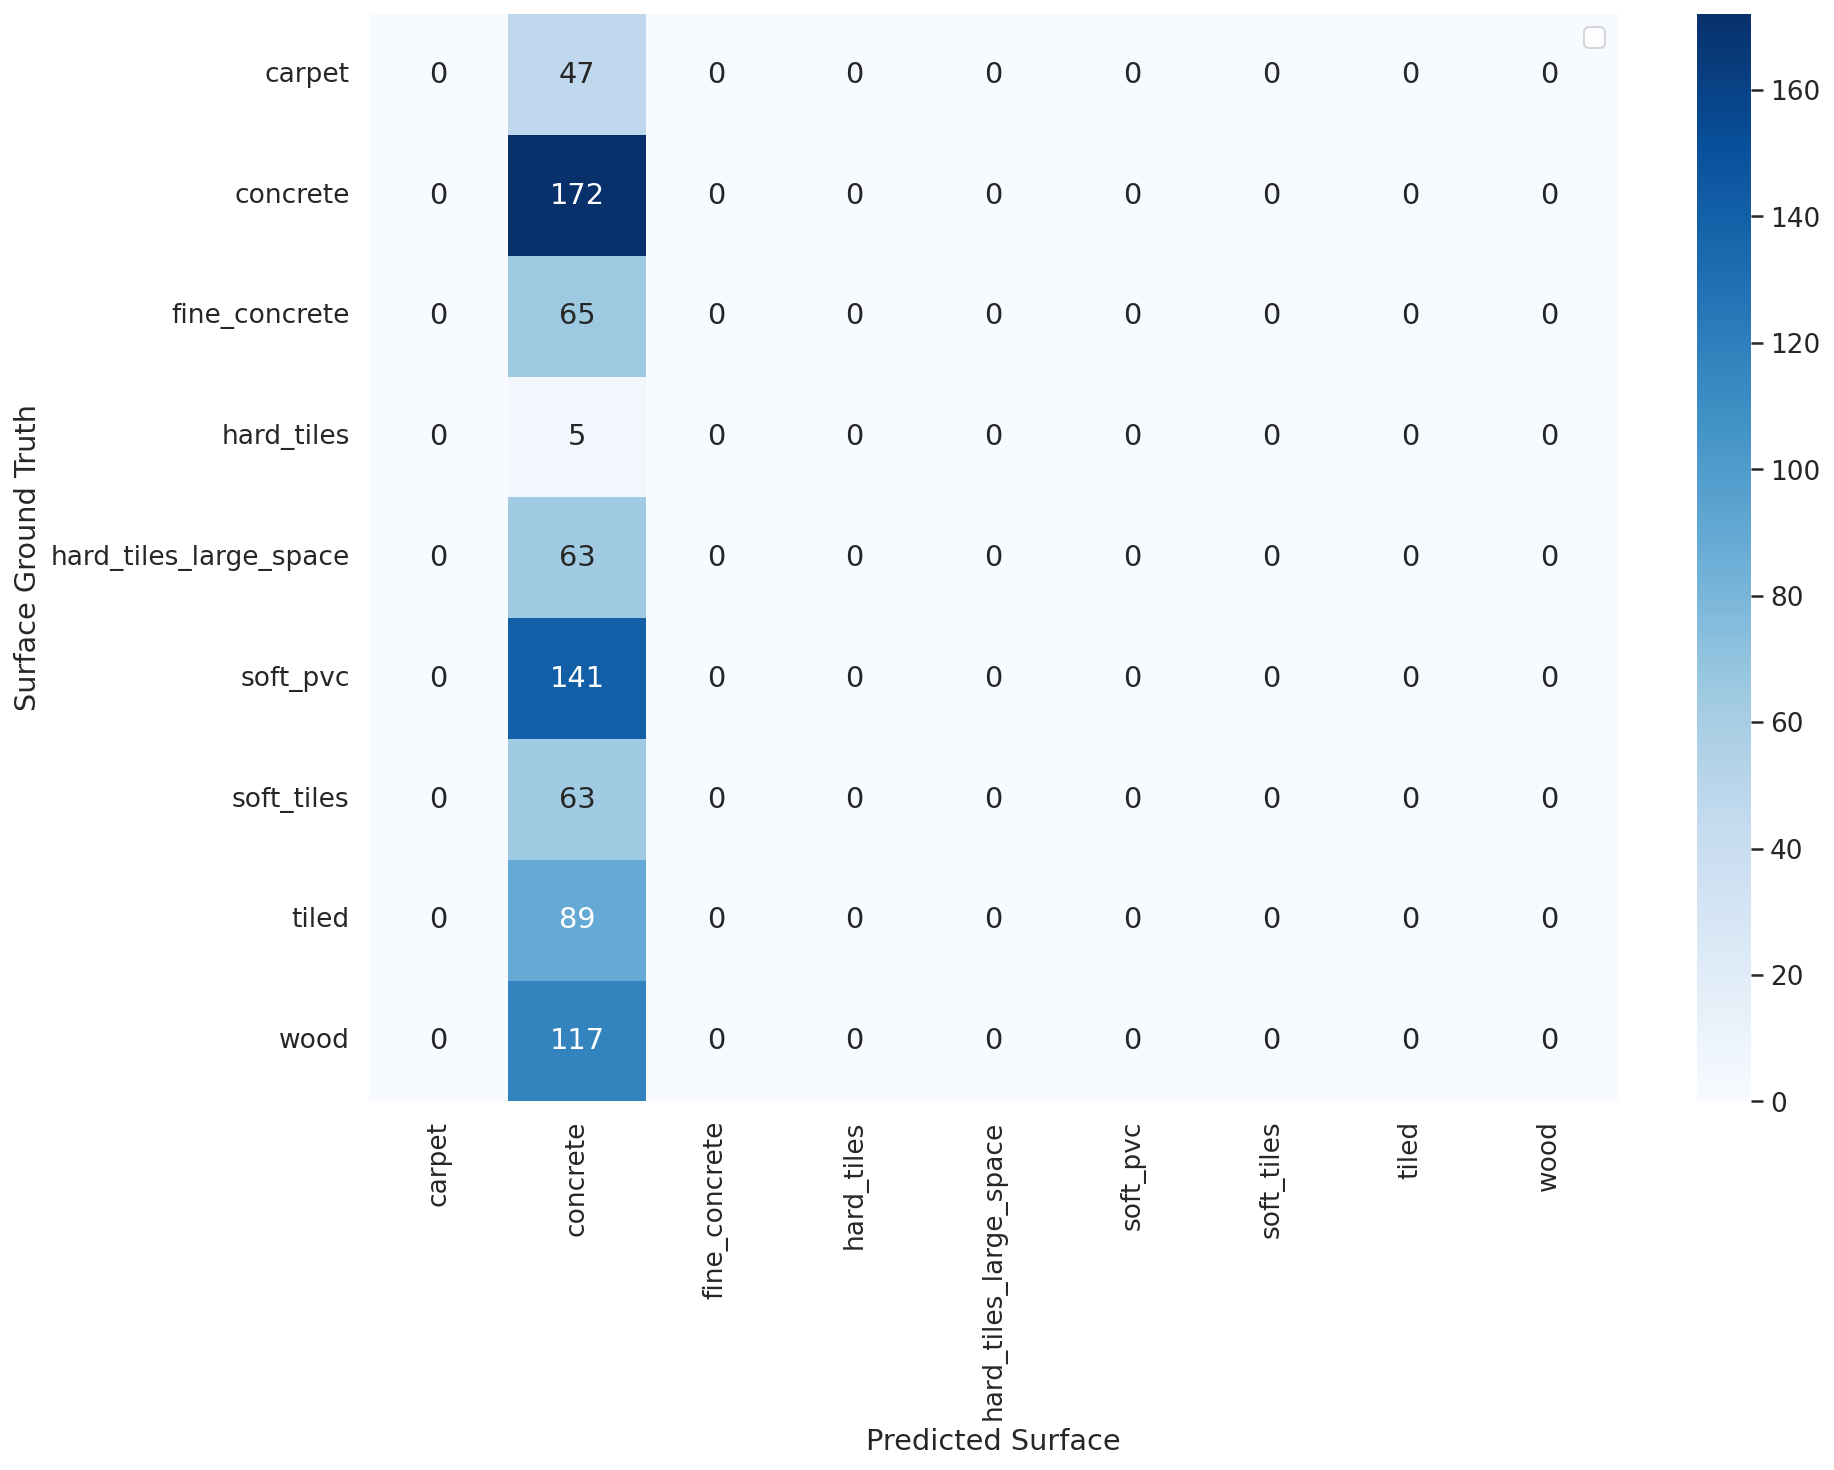

In [ ]:
show_confusion_matrix(df_cm)